# Multi-Layer Perceptron (Neural Network)
## Research Question: "Predict whether a stop and search will conclude in police action".

#### In this notebook we attempt to answer the research question using the data set (https://www.kaggle.com/sohier/london-police-records?select=london-stop-and-search.csv), and a Multilayer Perceptron.

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, Adadelta, SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score
from keras.utils import to_categorical

from os.path import exists
import util_smote as usm
import util

#SMOTE
from imblearn.over_sampling import SMOTE


In [21]:
# A function that takes in a model and trains it
def train_nn(model, path, X_train, y_train, eras=1, epochs=100, min_delta=0.0001, min_lr=0.0000001, stoping_patience=4, lr_patience=2):
    #One-Hot-encode y_train
    y_encoded = to_categorical(y_train)
    #Early Stopping callback- from ex7Part1 (lab 7 of Intro to AI module)
    early_stopping = EarlyStopping(monitor='loss', min_delta=min_delta, patience=stoping_patience, verbose=1)
    #Reduce learning rate callbck - from https://keras.io/api/callbacks/reduce_lr_on_plateau/ 
    reduce_learning_rate = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=lr_patience, min_lr=min_lr, verbose=1)
    for i in range(eras):
        print(f"Starting era {i}...")
        if exists(path):
            print("🚨 Model alredy exists!")
            print("Loading model...")
            del model
            model = load_model(path)
        model.fit(X_train, y_encoded, epochs=epochs, callbacks=[reduce_learning_rate, early_stopping])
        model.save(path)

# A function that takes in a model and evaluates it
def evaluate_nn(model, path, X_test, y_test):
    del model
    model = load_model(path)
    pred = model.predict(X_test)
    pred = np.argmax(pred, axis=1)
    y_encoded = to_categorical(y_test)
    y_comparison = np.argmax(y_encoded, axis=1) 
    accuracy = metrics.accuracy_score(y_comparison, pred)
    precision = metrics.precision_score(y_comparison, pred, average="weighted")
    matthew_coef = metrics.matthews_corrcoef(y_comparison, pred)
    print(f"\nAccuracy is {accuracy * 100}")
    print(f"\nPrecision is {precision * 100}")
    print(f"\nMatthew's correlation coefficient is {matthew_coef}")
    #Confusion Matrix
    util.confusion_plot(y_test=y_comparison, y_predictions=pred)


## Cleaning the Data

In [22]:
data = pd.read_csv("data.csv")
data = util.data_cleaner(data)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 165651 entries, 0 to 302621
Data columns (total 10 columns):
 #   Column                     Non-Null Count   Dtype              
---  ------                     --------------   -----              
 0   Type                       165651 non-null  object             
 1   Date                       165651 non-null  datetime64[ns, UTC]
 2   Latitude                   165651 non-null  float64            
 3   Longitude                  165651 non-null  float64            
 4   Gender                     165651 non-null  object             
 5   Age range                  165651 non-null  object             
 6   Officer-defined ethnicity  165651 non-null  object             
 7   Legislation                165651 non-null  object             
 8   Object of search           165651 non-null  object             
 9   Outcome                    165651 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(2), object(7)
memory 

## Encoding Data

In [23]:
data_encoded, encoders = util.data_encoder(data)
outcome_classes = encoders["Outcome Encoder"].classes_
data_encoded.head()

,Type,Date,Latitude,Longitude,Gender,Age range,Officer-defined ethnicity,Legislation,Object of search,Outcome
0,1,0,51.512286,-0.114491,1,1,0,4,8,6
1,1,0,51.512286,-0.114491,1,1,0,4,8,6
2,1,1,51.512286,-0.114491,1,1,4,4,8,6
4,0,2,51.512286,-0.114491,1,1,4,4,8,6
5,1,3,51.512286,-0.114491,1,1,0,3,3,2


## Splitting the Data

In [24]:
#Splt into X and y, while one-hot-encoding the target

target = data_encoded["Outcome"]
features = data_encoded.drop('Outcome', axis=1)

# Split into features and target
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=10)

## The MLP

We start with a basic MLP:
- Input
- Hidden (9 unit, relu activation)
- Output (8 unit, softmax)

### Build

In [25]:
simple_model = Sequential()
simple_model.add(Dense(9, input_dim=9, activation='relu'))
simple_model.add(Dense(8, activation='softmax'))
simple_model.compile(loss='categorical_crossentropy', optimizer='adam')

### Train

In [26]:
%%time

model_name = "simple(9_9_8)"
path = f"./models/{model_name}.h5"

train_nn(simple_model, path=path, X_train=X_train, y_train=y_train, eras=1, epochs=100, min_delta=0.00001, min_lr=0.0000001, stoping_patience=4, lr_patience=2)

Starting era 0...
🚨 Model alredy exists!
Loading model...
Epoch 1/100
4142/4142 [==============================] - 2s 459us/step - loss: 1.0166
Epoch 2/100
4142/4142 [==============================] - 2s 468us/step - loss: 1.0166
Epoch 3/100
4132/4142 [============================>.] - ETA: 0s - loss: 1.0168
Epoch 00003: ReduceLROnPlateau reducing learning rate to 1e-07.
4142/4142 [==============================] - 2s 450us/step - loss: 1.0166
Epoch 4/100
4142/4142 [==============================] - 2s 454us/step - loss: 1.0166
Epoch 5/100
4050/4142 [============================>.] - ETA: 0s - loss: 1.0165
Epoch 00005: ReduceLROnPlateau reducing learning rate to 1e-07.
4142/4142 [==============================] - 2s 459us/step - loss: 1.0165
Epoch 6/100
4142/4142 [==============================] - 2s 452us/step - loss: 1.0165
Epoch 7/100
4103/4142 [============================>.] - ETA: 0s - loss: 1.0166
Epoch 00007: ReduceLROnPlateau reducing learning rate to 1e-07.
4142/4142 [=======

### Evaluate


Accuracy is 63.41191029549365

Precision is 48.28093015179811

Matthew's correlation coefficient is -0.009698649183338515


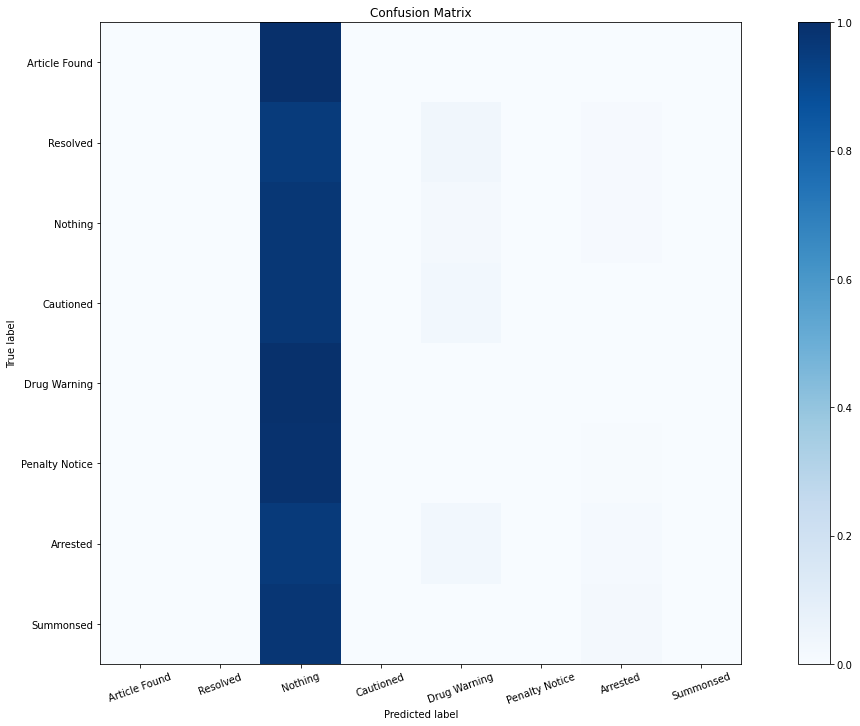

In [27]:
evaluate_nn(model=simple_model, path=path, X_test=X_test, y_test=y_test)

The model was able to predict test set 63% of the time. It is highly biased to predict class 2 ("Nothing found - no further action"), suggesting an underfit of the data.

## Adding More Hidden Layers

We try to add more layers to alleviate the underfitting of our model

### Build

In [28]:
model_more_hidden = Sequential()
model_more_hidden.add(Dense(9, input_dim=9, activation='relu')) # Hidden 1
model_more_hidden.add(Dense(9, activation='relu')) # Hidden 2
model_more_hidden.add(Dense(9, activation='relu')) # Hidden 3
model_more_hidden.add(Dense(8, activation='softmax')) # Ouput
model_more_hidden.compile(loss='categorical_crossentropy', optimizer='adam')

### Train

In [29]:
%%time

model_name = "simple(9_9_9_9_8)"
path = f"./models/{model_name}.h5"

train_nn(model_more_hidden, path=path, X_train=X_train, y_train=y_train, eras=1, epochs=100, min_delta=0.00001, min_lr=0.0000001, stoping_patience=4, lr_patience=2)

Starting era 0...
🚨 Model alredy exists!
Loading model...
Epoch 1/100
4142/4142 [==============================] - 2s 507us/step - loss: 1.0035
Epoch 2/100
4142/4142 [==============================] - 2s 517us/step - loss: 1.0035
Epoch 3/100
4113/4142 [============================>.] - ETA: 0s - loss: 1.0034
Epoch 00003: ReduceLROnPlateau reducing learning rate to 1e-07.
4142/4142 [==============================] - 2s 514us/step - loss: 1.0035
Epoch 4/100
4142/4142 [==============================] - 2s 517us/step - loss: 1.0035
Epoch 5/100
4058/4142 [============================>.] - ETA: 0s - loss: 1.0041
Epoch 00005: ReduceLROnPlateau reducing learning rate to 1e-07.
4142/4142 [==============================] - 2s 521us/step - loss: 1.0035
Epoch 00005: early stopping
CPU times: user 19.3 s, sys: 10.6 s, total: 29.9 s
Wall time: 10.9 s



Accuracy is 65.1082068153693

Precision is 57.39694396795231

Matthew's correlation coefficient is 0.010208085324035237


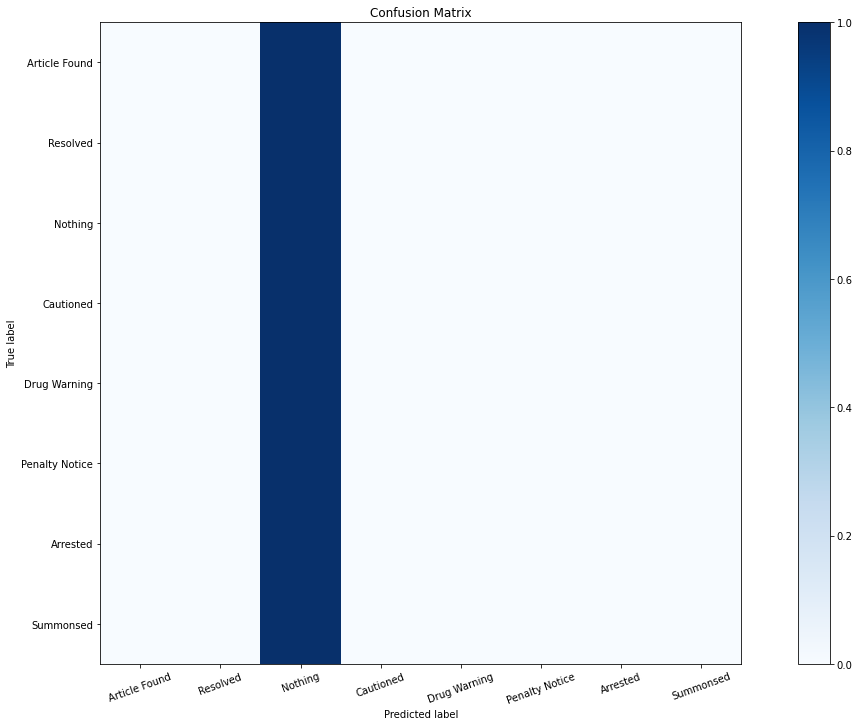

In [30]:
evaluate_nn(model=model_more_hidden, path=path, X_test=X_test, y_test=y_test)

Accuracy not signficantly improved... however, precision has increased.

# Sigmoid Activation

Let's try using sigmid instead of relu as our activation

### Build

In [31]:
sigmoid_model = Sequential()
sigmoid_model.add(Dense(9, input_dim=9, activation='sigmoid')) # Hidden 1
sigmoid_model.add(Dense(9, activation='sigmoid')) # Hidden 2
sigmoid_model.add(Dense(9, activation='sigmoid')) # Hidden 3
sigmoid_model.add(Dense(8, activation='softmax')) # Ouput
sigmoid_model.compile(loss='categorical_crossentropy', optimizer='adam')

### Train

In [32]:
%%time

model_name = "sigmoid(9_9_9_9_8)"
path = f"./models/{model_name}.h5"

train_nn(sigmoid_model, path=path, X_train=X_train, y_train=y_train, eras=1, epochs=100, min_delta=0.00001, min_lr=0.0000001, stoping_patience=4, lr_patience=2)

Starting era 0...
🚨 Model alredy exists!
Loading model...
Epoch 1/100
4142/4142 [==============================] - 2s 525us/step - loss: 1.0039
Epoch 2/100
4142/4142 [==============================] - 2s 520us/step - loss: 1.0039
Epoch 3/100
4100/4142 [============================>.] - ETA: 0s - loss: 1.0039
Epoch 00003: ReduceLROnPlateau reducing learning rate to 1e-07.
4142/4142 [==============================] - 2s 527us/step - loss: 1.0039
Epoch 4/100
4142/4142 [==============================] - 2s 522us/step - loss: 1.0039
Epoch 5/100
4096/4142 [============================>.] - ETA: 0s - loss: 1.0040
Epoch 00005: ReduceLROnPlateau reducing learning rate to 1e-07.
4142/4142 [==============================] - 2s 528us/step - loss: 1.0039
Epoch 00005: early stopping
CPU times: user 19.7 s, sys: 11.1 s, total: 30.8 s
Wall time: 11.1 s


### Evaluate


Accuracy is 65.1021701729498

Precision is 42.38292561227715

Matthew's correlation coefficient is 0.0


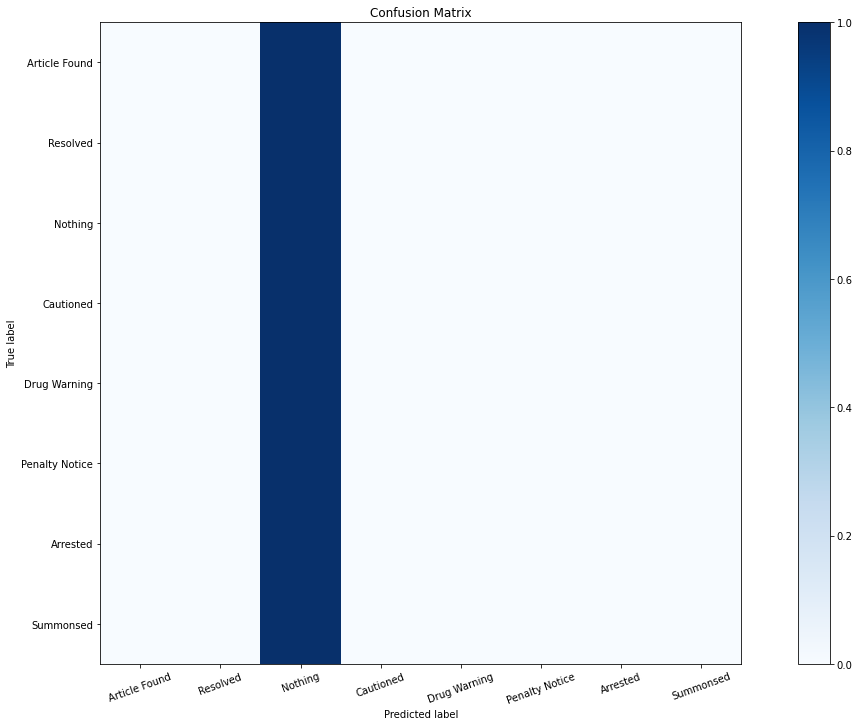

In [33]:
evaluate_nn(model=sigmoid_model, path=path, X_test=X_test, y_test=y_test)

Results worse. Relu is the superior activation function for that architecture.

# Using SMOTE 

The issue seems to be that a single class dominates the other classes by far in terms of frequency.

Class 0: 0.02%     (41)
Class 1: 0.68%     (1121)
Class 2: 65.41%     (108353)
Class 3: 0.1%     (167)
Class 4: 10.74%     (17788)
Class 5: 2.31%     (3824)
Class 6: 19.96%     (33067)
Class 7: 0.78%     (1290)
Total: 165651


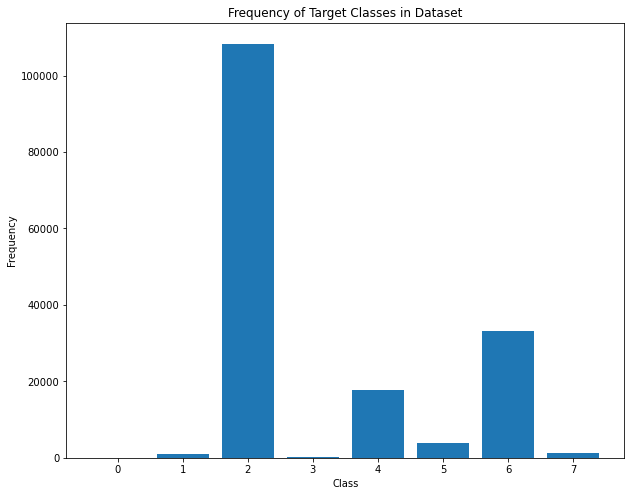

In [34]:
#The frequencies of each class in the dataset
usm.display_frequencies(data_encoded["Outcome"])

65% of the example targets belong to class 2! 

We can solve this by using SMOTE to generate artificial data for our minor classes.

### Preprocessing

Class 0: 12.5%     (86784)
Class 1: 12.5%     (86784)
Class 2: 12.5%     (86784)
Class 3: 12.5%     (86784)
Class 4: 12.5%     (86784)
Class 5: 12.5%     (86784)
Class 6: 12.5%     (86784)
Class 7: 12.5%     (86784)
Total: 694272


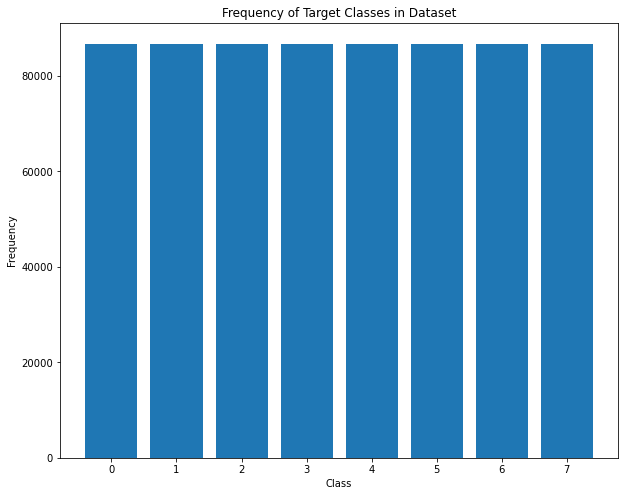

In [35]:
X_smote, y_smote = usm.smote_data(X_train, y_train)
y_encoded = to_categorical(y_smote)
usm.display_frequencies(y_smote)


After using SMOTE, the frequencies of each class have been equalized.

We can begin training now...

### Build Model

In [36]:
smote_model = Sequential()
smote_model.add(Dense(9, input_dim=9, activation='relu')) # Hidden 1
smote_model.add(Dense(9, activation='relu')) # Hidden 2
smote_model.add(Dense(9, activation='relu')) # Hidden 3
smote_model.add(Dense(8, activation='softmax')) # Ouput
smote_model.compile(loss='categorical_crossentropy', optimizer='adam')

### Train

In [37]:
%%time
model_name = "smoted(9_9_9_9_8)"
path = f"./models/{model_name}.h5"

train_nn(smote_model, path=path, X_train=X_smote, y_train=y_smote, eras=1, epochs=100, min_delta=0.00001, min_lr=0.0000001, stoping_patience=4, lr_patience=2)


Starting era 0...
🚨 Model alredy exists!
Loading model...
Epoch 1/100
21696/21696 [==============================] - 11s 509us/step - loss: 2.0739
Epoch 2/100
21696/21696 [==============================] - 11s 514us/step - loss: 2.0739
Epoch 3/100
21686/21696 [============================>.] - ETA: 0s - loss: 2.0739
Epoch 00003: ReduceLROnPlateau reducing learning rate to 1e-07.
21696/21696 [==============================] - 11s 524us/step - loss: 2.0739
Epoch 4/100
21696/21696 [==============================] - 12s 537us/step - loss: 2.0739
Epoch 5/100
21649/21696 [============================>.] - ETA: 0s - loss: 2.0739
Epoch 00005: ReduceLROnPlateau reducing learning rate to 1e-07.
21696/21696 [==============================] - 11s 527us/step - loss: 2.0739
Epoch 6/100
21696/21696 [==============================] - 11s 523us/step - loss: 2.0739
Epoch 7/100
21652/21696 [============================>.] - ETA: 0s - loss: 2.0739
Epoch 00007: ReduceLROnPlateau reducing learning rate to 1

### Evaluate


Accuracy is 0.13884277564818448

Precision is 4.169803853362685

Matthew's correlation coefficient is -0.0006097721634380453


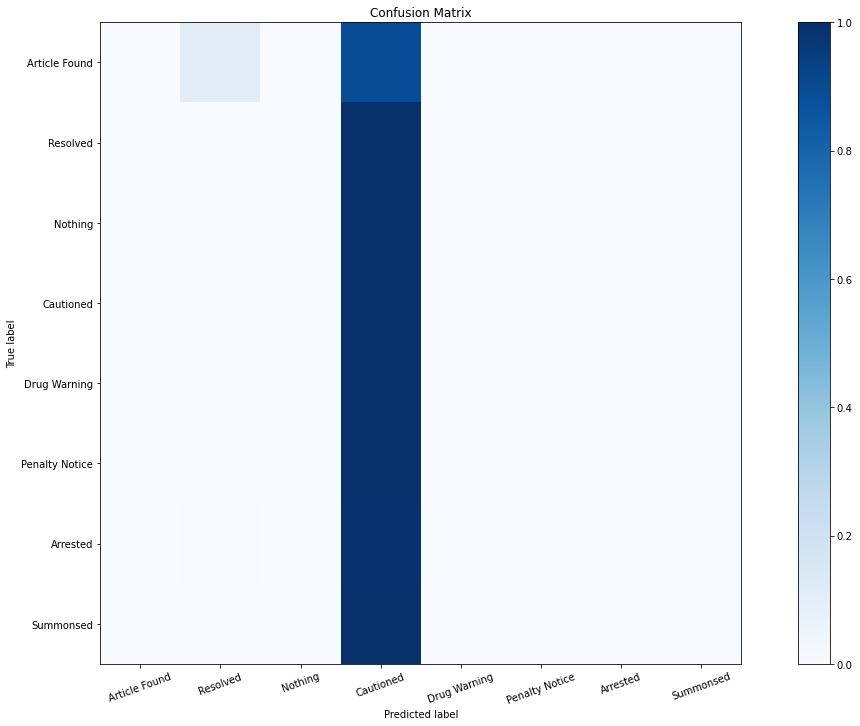

In [38]:
evaluate_nn(model=smote_model, path=path, X_test=X_test, y_test=y_test)

Accuracy is obviously much worse, but the model is not blindly selecting the majority class anymore. Given the increased size of the data (added aritifical data), we try a large network.

## SMOTE (Playground)

Find a tabulation of all tested models, and their confusion matrices, inside: 
- src/models/Models tested.pages 
- src/models/Confusion Matrix

In [39]:
smote_model = Sequential()

smote_model.add(Dense(60, input_dim=9, activation='relu'))
smote_model.add(Dropout(0.04))
for i in range(20):
    smote_model.add(Dense(60, activation='relu'))
smote_model.add(Dense(8, activation='softmax'))
smote_model.compile(loss='categorical_crossentropy', optimizer='adam')

In [40]:
%%time
model_name = "dropout_model(60_dropout(0.04)_60x20_8)"
path = f"./models/{model_name}.h5"

train_nn(smote_model, path=path, X_train=X_smote, y_train=y_smote, eras=1, epochs=95, min_delta=0.0001, min_lr=1e-10, stoping_patience=4, lr_patience=2)

Starting era 0...
🚨 Model alredy exists!
Loading model...
Epoch 1/95
21696/21696 [==============================] - 33s 2ms/step - loss: 1.7733
Epoch 2/95
21696/21696 [==============================] - 32s 1ms/step - loss: 1.7733
Epoch 3/95
21672/21696 [============================>.] - ETA: 0s - loss: 1.7734
Epoch 00003: ReduceLROnPlateau reducing learning rate to 2.5600002118153498e-09.
21696/21696 [==============================] - 33s 2ms/step - loss: 1.7733
Epoch 4/95
21696/21696 [==============================] - 32s 1ms/step - loss: 1.7733
Epoch 5/95
21682/21696 [============================>.] - ETA: 0s - loss: 1.7733
Epoch 00005: ReduceLROnPlateau reducing learning rate to 5.1200004236307e-10.
21696/21696 [==============================] - 32s 1ms/step - loss: 1.7733
Epoch 00005: early stopping
CPU times: user 8min 7s, sys: 8min 47s, total: 16min 54s
Wall time: 2min 42s



Accuracy is 4.4731520328393355

Precision is 50.22083141836997

Matthew's correlation coefficient is 0.005451040943193481


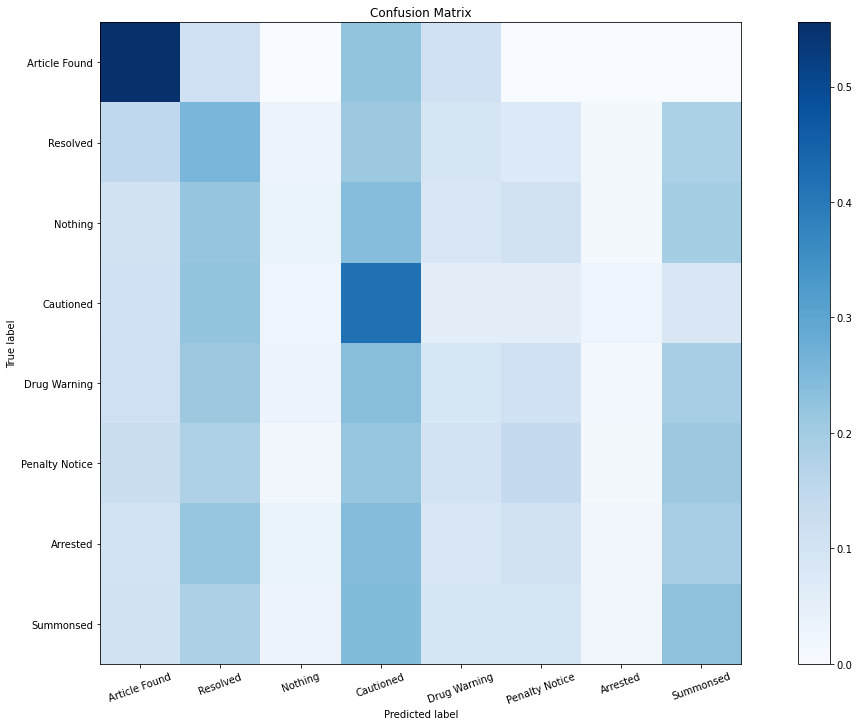

In [41]:
evaluate_nn(model=smote_model, path=path, X_test=X_test, y_test=y_test)

## Using Scaled Data

In [42]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
X_scaled = pd.DataFrame(features_scaled, columns=data.drop("Outcome", axis=1).columns)

X_scaled.head()

,Type,Date,Latitude,Longitude,Gender,Age range,Officer-defined ethnicity,Legislation,Object of search
0,0.641784,-1.720167,0.031037,0.055872,0.265176,0.379816,-1.346153,1.233580,7.911489
1,0.641784,-1.720167,0.031037,0.055872,0.265176,0.379816,-1.346153,1.233580,7.911489
2,0.641784,-1.720133,0.031037,0.055872,0.265176,0.379816,1.062035,1.233580,7.911489
3,-1.526923,-1.720099,0.031037,0.055872,0.265176,0.379816,1.062035,1.233580,7.911489
4,0.641784,-1.720065,0.031037,0.055872,0.265176,0.379816,-1.346153,-0.453747,0.417036


In [43]:
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, target, test_size=0.2, random_state=10)
X_smote_scaled, y_smote_scaled = usm.smote_data(X_train_scaled, y_train_scaled)

### Build the model

In [48]:
smote_model = Sequential()

smote_model.add(Dense(60, input_dim=9, activation='relu'))
smote_model.add(Dropout(0.04))
smote_model.add(Dense(60, activation='relu'))
for i in range(7):
    smote_model.add(Dense(256, activation='relu'))
smote_model.add(Dense(8, activation='softmax'))
smote_model.compile(loss='categorical_crossentropy', optimizer='adam')

### Train

In [50]:
%%time
model_name = "scaled(60_dropout(0.04)_60_256x7_8)"
path = f"./models/{model_name}.h5"

train_nn(smote_model, path=path, X_train=X_smote_scaled, y_train=y_smote_scaled, eras=1, epochs=95, min_delta=0.0001, min_lr=1e-10, stoping_patience=4, lr_patience=2)

Starting era 0...
Epoch 1/95
21696/21696 [==============================] - 40s 2ms/step - loss: 1.3795
Epoch 2/95
21696/21696 [==============================] - 40s 2ms/step - loss: 1.2249
Epoch 3/95
21696/21696 [==============================] - 40s 2ms/step - loss: 1.1744
Epoch 4/95
21696/21696 [==============================] - 40s 2ms/step - loss: 1.1444
Epoch 5/95
21696/21696 [==============================] - 40s 2ms/step - loss: 1.1250
Epoch 6/95
21696/21696 [==============================] - 39s 2ms/step - loss: 1.1105
Epoch 7/95
21696/21696 [==============================] - 188s 9ms/step - loss: 1.0982
Epoch 8/95
21696/21696 [==============================] - 323s 15ms/step - loss: 1.0909
Epoch 9/95
21696/21696 [==============================] - 319s 15ms/step - loss: 1.0817
Epoch 10/95
21696/21696 [==============================] - 316s 15ms/step - loss: 1.0722
Epoch 11/95
21696/21696 [==============================] - 306s 14ms/step - loss: 1.0686
Epoch 12/95
21696/21696 [

### Evaluate


Accuracy is 20.095982614469833

Precision is 52.63564496321176

Matthew's correlation coefficient is 0.06829946440799084


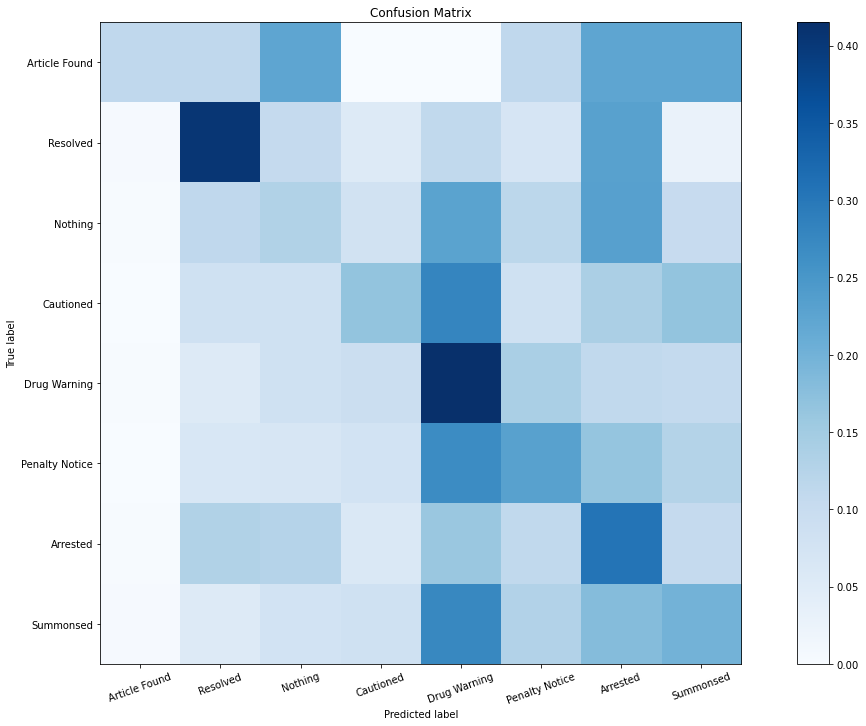

In [51]:
evaluate_nn(model=smote_model, path=path, X_test=X_test_scaled, y_test=y_test_scaled)